In [88]:
import pytz
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
API_KEY='-'
BASE_URL='https://api.openweathermap.org/data/2.5/'

In [90]:
def get_current_weather(city):
    url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)  
    data = response.json()
    return {
        'city': data['name'],
        'current_temp': round(data['main']['temp']),
        'feels_like': round(data['main']['feels_like']),
        'temp_min': round(data['main']['temp_min']),
        'temp_max': round(data['main']['temp_max']),
        'humidity': round(data['main']['humidity']),
        'description': data['weather'][0]['description'],
        'country': data['sys']['country'],
        'wind_gust_dir': data['wind'].get('deg', 0),
        'pressure': data['main']['pressure'],
        'Wind_Gust_Speed': data['wind'].get('speed', 0)
    }


In [91]:
def read_historical_data(filename):
    df=pd.read_csv(filename)
    df=df.dropna()
    df=df.drop_duplicates()
    return df

In [92]:
def prepare_data(data):
    le=LabelEncoder()
    data['WindGustDir']=le.fit_transform(data['WindGustDir'])
    data['RainTomorrow']=le.fit_transform(data['RainTomorrow'])

    x=data[['MinTemp','MaxTemp','WindGustDir','WindGustSpeed','Humidity','Pressure','Temp','RainTomorrow']]

    y=data['RainTomorrow']

    return x,y,le

In [93]:
def Train_rain_model(x,y):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    model=RandomForestClassifier(n_estimators=100,random_state=42)
    model.fit(x_train,y_train)

    y_pred=model.predict(x_test)
    print("Mean sq error for rain model")
    print(mean_squared_error(y_test,y_pred))

    return model

In [94]:
def prepare_regression_data(data,feature):
    x,y=[],[]

    for i in range(len(data)-1):
        x.append(data[feature].iloc[i])
        y.append(data[feature].iloc[i+1])

    x=np.array(x).reshape(-1,1)
    y=np.array(y)
    return x,y


In [95]:
def train_regression_model(x,y):
    model=RandomForestRegressor(n_estimators=100,random_state=42)
    model.fit(x,y)
    return model

In [96]:
def predict_future(model,current_value):
    predictions=[current_value]
    for i in range(5):
        next_value=model.predict(np.array([[predictions[-1]]]))
        predictions.append(next_value[0])

    return predictions[1:]

Enter City Name:  Kolkata


Mean sq error for rain model
0.0
City: Kolkata, IN
Current Temperature: 30°C
Feels Like: 33°C
Minimum Temperature: 30°C
Maximum Temperature: 30°C
Humidity: 62%
Weather Prediction: haze
Rain Prediction: No

Future Temperature Predictions: 
22:00: 28.5°C
23:00: 22.0°C
00:00: 23.9°C
01:00: 21.4°C
02:00: 22.7°C

Future Humidity Predictions: 
22:00: 56.5%
23:00: 40.7%
00:00: 52.9%
01:00: 51.0%
02:00: 46.6%


<ipython-input-130-9a396a0098f4>:3: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



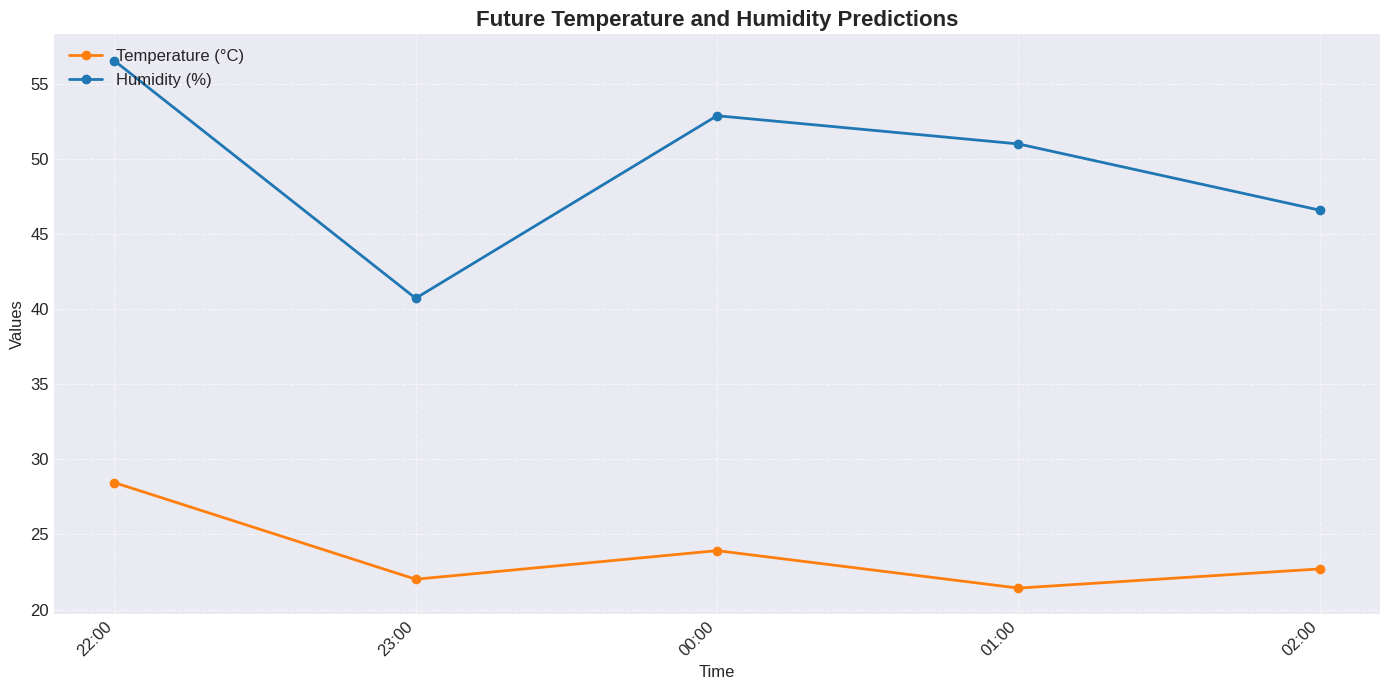

In [131]:
def weather_view():
    city = input("Enter City Name: ")
    current_weather = get_current_weather(city)

    historical_data = read_historical_data('/kaggle/input/weather/weather.csv')

    x, y, le = prepare_data(historical_data)

    rain_model = Train_rain_model(x, y)

    # Map wind direction to compass coordinates
    wind_deg = current_weather['wind_gust_dir'] % 360
    compass_points = [
        ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
        ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
        ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
        ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
        ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
        ("NNW", 326.25, 348.75)
    ]
    compass_direction = next(point for point, start, end in compass_points if start <= wind_deg < end)
    compass_direction_encoded = le.transform([compass_direction])[0] if compass_direction in le.classes_ else -1
    
    current_data = {
        'MinTemp': current_weather['temp_min'],
        'MaxTemp': current_weather['temp_max'],
        'WindGustDir': compass_direction_encoded,
        'WindGustSpeed': current_weather['Wind_Gust_Speed'],
        'Humidity': current_weather['humidity'],
        'Pressure': current_weather['pressure'],
        'Temp': current_weather['current_temp'],
        'RainTomorrow': 0
    }
    current_df = pd.DataFrame([current_data])

    rain_predictions = rain_model.predict(current_df)[0]

    x_temp, y_temp = prepare_regression_data(historical_data, 'Temp')
    x_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')

    temp_model = train_regression_model(x_temp, y_temp)
    hum_model = train_regression_model(x_hum, y_hum)

    future_temp = predict_future(temp_model, current_weather['temp_min'])
    future_humidity = predict_future(hum_model, current_weather['humidity'])

    timezone = pytz.timezone('Asia/Kolkata')
    now = datetime.now(timezone)
    next_hour = now + timedelta(hours=1)
    next_hour = next_hour.replace(minute=0, second=0, microsecond=0)

    future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]

    print(f"City: {city}, {current_weather['country']}")
    print(f"Current Temperature: {current_weather['current_temp']}°C")
    print(f"Feels Like: {current_weather['feels_like']}°C")
    print(f"Minimum Temperature: {current_weather['temp_min']}°C")
    print(f"Maximum Temperature: {current_weather['temp_max']}°C")
    print(f"Humidity: {current_weather['humidity']}%")
    print(f"Weather Prediction: {current_weather['description']}")
    print(f"Rain Prediction: {'Yes' if rain_predictions else 'No'}")

    print("\nFuture Temperature Predictions: ")
    for time, temp in zip(future_times, future_temp):
        print(f"{time}: {round(temp, 1)}°C")

    print("\nFuture Humidity Predictions: ")
    for time, humidity in zip(future_times, future_humidity):
        print(f"{time}: {round(humidity, 1)}%")

    return future_times, future_temp, future_humidity

future_times, future_temp, future_humidity = weather_view()

plot_weather_predictions(future_times, future_temp, future_humidity)

def plot_weather_predictions(future_times, future_temp, future_humidity):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(14, 7))
    plt.plot(future_times, future_temp, marker='o', color='#FF7F0E', label="Temperature (°C)", linewidth=2, markersize=6)
    plt.plot(future_times, future_humidity, marker='o', color='#1F77B4', label="Humidity (%)", linewidth=2, markersize=6)

    plt.title("Future Temperature and Humidity Predictions", fontsize=16, fontweight='bold')
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Values", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()
